# Real Cube: Motion Extraction & Mode Identification
This notebook shows how to extract image-space modal observations from a video of a cube. For a damped cube, we typically need to extract modes from multiple videos, so this notebook must be run for every video that will be used for material-property estimation. In this demo, we'll work with the real Jello cube. **Note:** the outputs of this notebook for all the videos of the real Jello cube are already provided in the Box folder. If you just want to reconstruct the material properties, you can skip to `demo2.2_realcube_inference.ipynb`.

For each video, this notebook writes a `modal_observations.pkl` file, which contains the observed (unsampled) image-space modes and their frequencies. It also asks you to click on the locations of reference mesh points and saves them in a `clicks.npy` file. These reference points will be used to sample the image-space modes at visible mesh vertices in the `demo2.2_real_cube_inference.ipynb` notebook.

In order to recreate Figs. 10 and 11 in the paper, you will need to run this notebook entirely for each of the three videos provided for the Jello cube.

## 0. Download Data
The Jello-cube videos can be downloaded from here: https://caltech.box.com/s/sect508u93m7ik43bzk95fr8rl42rr14.
Please place the folder in `real_data` so that the file structure looks like:
```
real_data/jello_cube/
    top_front_pluck/
        top_front_pluck-4000fps.avi
    top_right_pluck/
        top_right_pluck-4000fps.avi
    left_side_twist/
        left_side_twist-4000fps.avi
```

In [1]:
import pickle

import numpy as np
import matplotlib.pyplot as plt
import cv2
import vvt

fps = 30

In [2]:
"""
Set the options of this run.
"""
# Set the video name to determine which video to work with in this run.
video = 'resonance-test'
# assert video in videos

N_THREADS = 8  # num. threads to use in multithreaded functions

## 1. Motion Extraction

Reading AVI: data/resonance-test.mp4


Reading frames: 100%|██████████████████████| 6674/6674 [00:08<00:00, 748.45it/s]


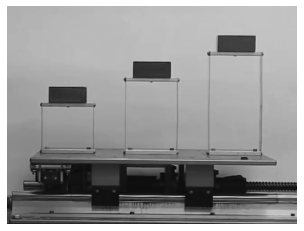

In [3]:
"""
Read the frames and show the first frame of the video.
"""
# avi_fn = 'real_data/jello_cube/%s/%s-%dfps.avi' % (video, video, fps)
avi_fn = 'data/resonance-test.mp4'
print('Reading AVI:', avi_fn)

frames = vvt.motion.read_frames(avi_fn)
plt.imshow(frames[500], cmap='gray')
plt.axis('off')
plt.show()

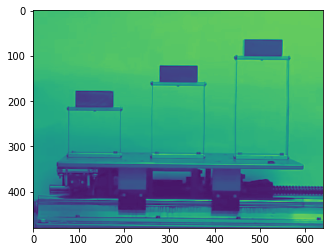

In [4]:
# uncomment for videos captured on our camera
# frames = [cv2.resize(frame, (frames[0].shape[1]//3, frames[0].shape[0] // 3)) for frame in frames]
# frames = [cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE) for frame in frames]
# %matplotlib
plt.imshow(frames[400])

In [5]:
"""
Run motion extraction and then apply amplitude-weighted Gaussian smoothing to the 
displacement fields.
"""
# Some videos have large motion at the beginning, so we have to start from a later frame.
start_frames = {
    'youtubebridge': 100,
    'tree-and-clouds': 100,
    'tree2': 100,
    'wire-and-tree' : 50,
    'resonance-test' : 750, 
}
end_frames = {
    'youtubebridge' : 1500,
    'tree-and-clouds' : 1200,
    'tree2' : 1200,
    'wire-and-tree' : 700,
    'resonance-test':3150 , 
}

t_start, t_end = start_frames[video], end_frames[video]
ref_frame = frames[t_start]
motion_fields = vvt.motion.extract_motion(
    frames[t_start:t_end], ref_frame, filter_pct=98, n_threads=N_THREADS)
motion_fields = vvt.motion.weighted_gaussian_smooth(
    motion_fields, ref_frame, sigma=4, n_threads=N_THREADS)

Running motion extraction in 8 threads...
[Thread 0] 100 / 300 frames processed in 43.5 seconds.
[Thread 0] 200 / 300 frames processed in 42.0 seconds.
[Thread 0] 300 / 300 frames processed in 41.1 seconds.
Done! Elapsed time: 0:02:07.571435
Running amplitude-weighted Gaussian smoothing in 8 threads...
Done! Elapsed time: 0:00:23.380088


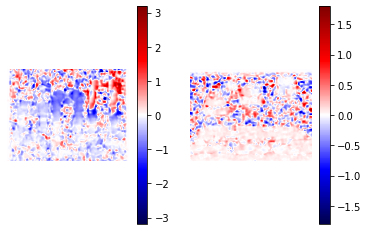

In [6]:
"""
View the displacement field at one frame.
"""
t = 1000
plt.subplot(121)
vvt.vis.plot_motion_field(motion_fields[0][t])
plt.subplot(122)
vvt.vis.plot_motion_field(motion_fields[1][t])

## 2. Mode Identification

In [7]:
"""
Run 1D FFT on displacement fields.
`fft_dx[i]` contains the FFT coefficients of horizontal motion at FFT bin i.
`fft_dy[i]` contains the FFT coefficients of vertical motion at FFT bin i.
`spectrum` is the power spectrum of horizontal + vertical motion amplitude.
`ffreqs[i]` is the frequency [Hz] of FFT bin i.
"""
max_fft_freq = 50  # max. frequency (in Hz) to consider
fft_dx, fft_dy, spectrum, ffreqs = vvt.modes.get_fft_results(
    motion_fields, fps, max_fft_freq, n_threads=N_THREADS)
log_spectrum = np.log(spectrum)

Running FFT in 8 threads...
[Thread 0] 5 / 60 rows processed in 2.0 seconds.
[Thread 0] 10 / 60 rows processed in 2.0 seconds.
[Thread 0] 15 / 60 rows processed in 2.0 seconds.
[Thread 0] 20 / 60 rows processed in 2.0 seconds.
[Thread 0] 25 / 60 rows processed in 1.9 seconds.
[Thread 0] 30 / 60 rows processed in 1.9 seconds.
[Thread 0] 35 / 60 rows processed in 1.9 seconds.
[Thread 0] 40 / 60 rows processed in 1.9 seconds.
[Thread 0] 45 / 60 rows processed in 1.9 seconds.
[Thread 0] 50 / 60 rows processed in 1.9 seconds.
[Thread 0] 55 / 60 rows processed in 1.9 seconds.
[Thread 0] 60 / 60 rows processed in 1.9 seconds.
Done! Elapsed time: 0:00:23.887354


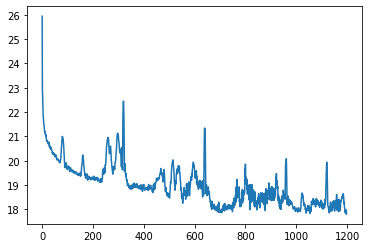

In [26]:
# %matplotlib notebook
plt.plot(np.arange(len(log_spectrum)), log_spectrum)

<IPython.core.display.Javascript object>


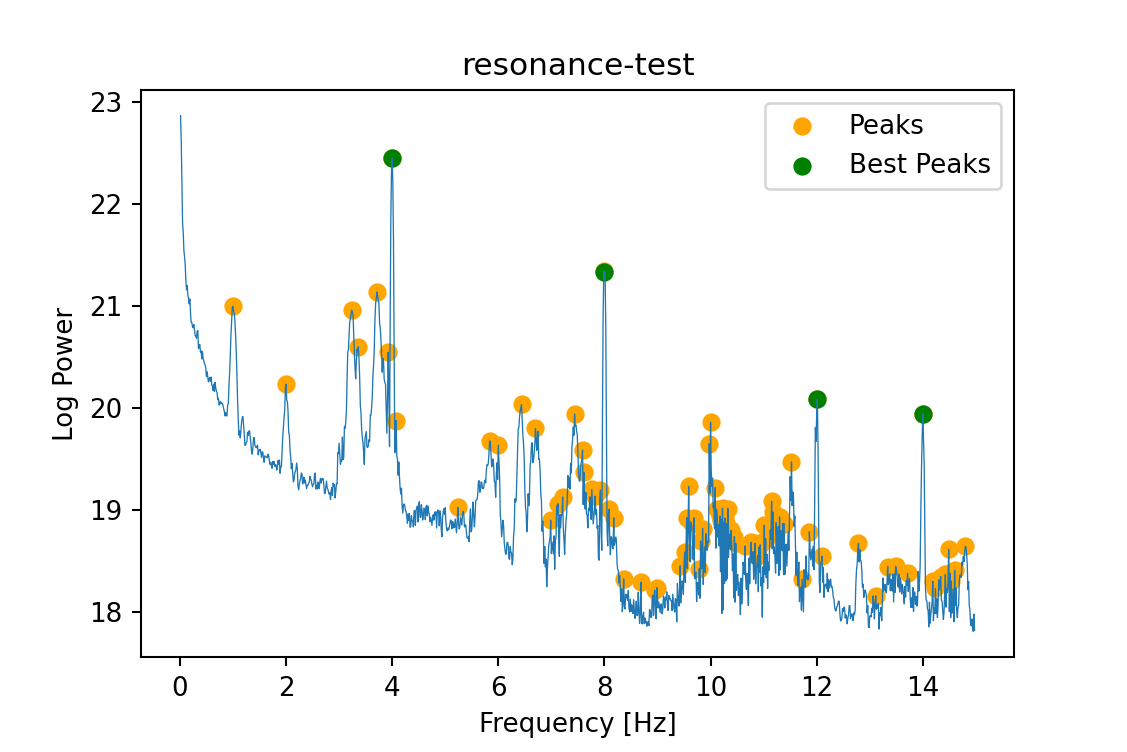

In [23]:
"""
Find peaks in the log-power spectrum of motion amplitude.
`best_peak_idxs_per_video` contains the best peaks that were
selected qualitatively.
"""
best_peak_idxs_per_video = {
    'top_front_pluck': [21, 25, 59],  # FFT bin indices
    'top_right_pluck': [25, 32, 60, 99],
    'left_side_twist': [25, 31, 65],
    'youtubebridge' : [36,66,96,129], #,210,308]
    'tree-and-clouds' : [92,126,227], #[18,40,64,92]
    'tree2' : [5,15,29,58],
    'resonance-test' : [320, 640, 961, 1120] #[220,440,661]
}
max_fft_idx = vvt.utils.find_nearest(ffreqs, max_fft_freq)
peak_idxs = vvt.modes.find_peak_idxs(log_spectrum[:max_fft_idx], prominence=0.01)
best_peak_idxs = best_peak_idxs_per_video[video]

plt.plot(ffreqs[1:max_fft_idx], log_spectrum[1:max_fft_idx], linewidth=0.5)
plt.scatter(
    ffreqs[peak_idxs], log_spectrum[peak_idxs], color='orange',
    label='Peaks')
plt.scatter(
    ffreqs[best_peak_idxs], log_spectrum[best_peak_idxs], color='green',
    label='Best Peaks')
plt.legend()
plt.xlabel('Frequency [Hz]')
plt.ylabel('Log Power')
plt.title(video)
plt.show()

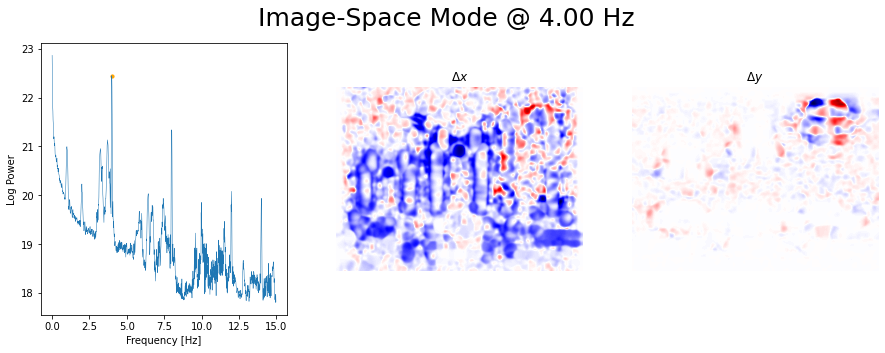

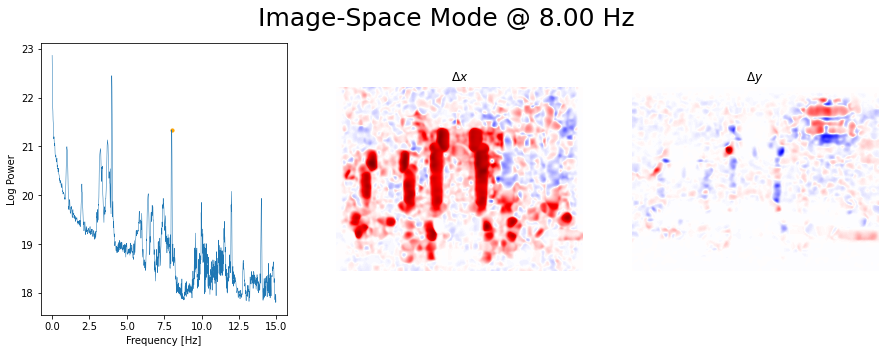

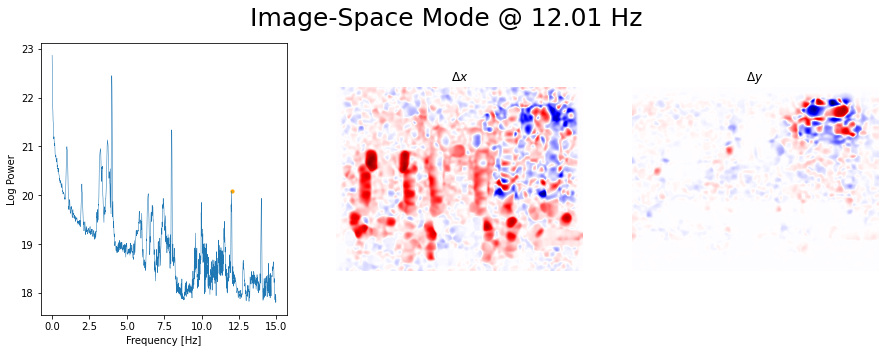

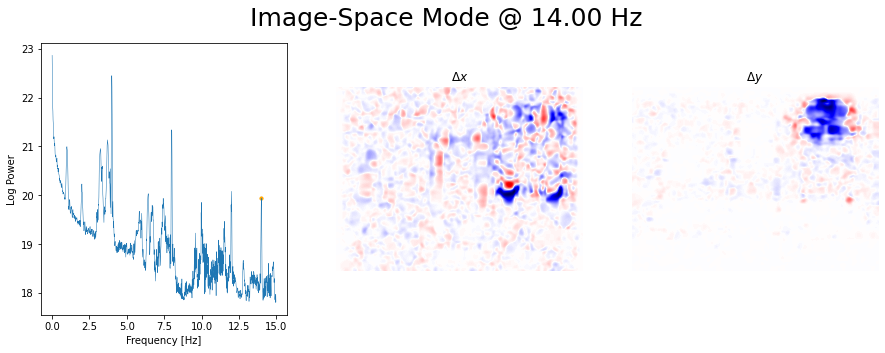

In [24]:
"""
View a specified image-space mode.
"""
%matplotlib inline
fft_idx = best_peak_idxs[0]

mode_shape_dx = fft_dx[fft_idx].real
mode_shape_dy = fft_dy[fft_idx].real
mode_freq = ffreqs[fft_idx]

fig = plt.figure(figsize=(15, 5))
fig.suptitle('Image-Space Mode @ %.2f Hz' % mode_freq, fontsize=25)

plt.subplot(131)
plt.plot(ffreqs[1:max_fft_idx], log_spectrum[1:max_fft_idx], linewidth=0.5)
plt.scatter(ffreqs[fft_idx], log_spectrum[fft_idx], c='orange', s=10)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Log Power')

plt.subplot(132)
vvt.vis.plot_motion_field(mode_shape_dx, cbar=False)
plt.title('$\Delta x$')
plt.axis('off')

plt.subplot(133)
vvt.vis.plot_motion_field(mode_shape_dy, cbar=False)
plt.title('$\Delta y$')
plt.axis('off')
plt.show()

fft_idx = best_peak_idxs[1]

mode_shape_dx = fft_dx[fft_idx].real
mode_shape_dy = fft_dy[fft_idx].real
mode_freq = ffreqs[fft_idx]

fig = plt.figure(figsize=(15, 5))
fig.suptitle('Image-Space Mode @ %.2f Hz' % mode_freq, fontsize=25)

plt.subplot(131)
plt.plot(ffreqs[1:max_fft_idx], log_spectrum[1:max_fft_idx], linewidth=0.5)
plt.scatter(ffreqs[fft_idx], log_spectrum[fft_idx], c='orange', s=10)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Log Power')

plt.subplot(132)
vvt.vis.plot_motion_field(mode_shape_dx, cbar=False)
plt.title('$\Delta x$')
plt.axis('off')

plt.subplot(133)
vvt.vis.plot_motion_field(mode_shape_dy, cbar=False)
plt.title('$\Delta y$')
plt.axis('off')
plt.show()

fft_idx = best_peak_idxs[2]

mode_shape_dx = fft_dx[fft_idx].real
mode_shape_dy = fft_dy[fft_idx].real
mode_freq = ffreqs[fft_idx]

fig = plt.figure(figsize=(15, 5))
fig.suptitle('Image-Space Mode @ %.2f Hz' % mode_freq, fontsize=25)

plt.subplot(131)
plt.plot(ffreqs[1:max_fft_idx], log_spectrum[1:max_fft_idx], linewidth=0.5)
plt.scatter(ffreqs[fft_idx], log_spectrum[fft_idx], c='orange', s=10)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Log Power')

plt.subplot(132)
vvt.vis.plot_motion_field(mode_shape_dx, cbar=False)
plt.title('$\Delta x$')
plt.axis('off')

plt.subplot(133)
vvt.vis.plot_motion_field(mode_shape_dy, cbar=False)
plt.title('$\Delta y$')
plt.axis('off')
plt.show()


fft_idx = best_peak_idxs[3]

mode_shape_dx = fft_dx[fft_idx].real
mode_shape_dy = fft_dy[fft_idx].real
mode_freq = ffreqs[fft_idx]

fig = plt.figure(figsize=(15, 5))
fig.suptitle('Image-Space Mode @ %.2f Hz' % mode_freq, fontsize=25)

plt.subplot(131)
plt.plot(ffreqs[1:max_fft_idx], log_spectrum[1:max_fft_idx], linewidth=0.5)
plt.scatter(ffreqs[fft_idx], log_spectrum[fft_idx], c='orange', s=10)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Log Power')

plt.subplot(132)
vvt.vis.plot_motion_field(mode_shape_dx, cbar=False)
plt.title('$\Delta x$')
plt.axis('off')

plt.subplot(133)
vvt.vis.plot_motion_field(mode_shape_dy, cbar=False)
plt.title('$\Delta y$')
plt.axis('off')
plt.show()

In [25]:
"""
Take the image-space modes at the best peaks, and save them as
modal observation data.
"""
image_space_modes_dx, image_space_modes_dy = vvt.modes.gather_image_space_modes(
    fft_dx, fft_dy, best_peak_idxs)
image_space_modes_freqs = ffreqs[best_peak_idxs]

data_dict = {
    'modes_dx': image_space_modes_dx,
    'modes_dy': image_space_modes_dy,
    'freqs': image_space_modes_freqs
}

modal_data_file = 'data/%s/modal_observations.pkl' % video
with open(modal_data_file, 'wb') as fp:
    pickle.dump(data_dict, fp)
print('Wrote:', modal_data_file)

Wrote: data/resonance-test/modal_observations2.pkl


In [ ]:
with open('real_data/jello_cube/%s/info_dict_10x10x10_deg1.pkl' % video, 'rb') as fp:
    ref = pickle.load(fp)

## 3. Reference Keypoints
We will need the pixel locations of reference mesh points (i.e., the 7 visible corners).
Click the following points in the exact order:
1. bottom left
2. bottom middle
3. bottom right
4. top left back
5. top left front
6. top right back
7. top right front

In [ ]:
"""
Click on the locations of the 7 reference points.
"""
%matplotlib notebook
clicks = []
vvt.utils.prompt_clicks(ref_frame, clicks, cmap='gray')

In [ ]:
"""
Save the clicked locations and view them on a video frame.
"""
np.save('real_data/jello_cube/%s/clicks.npy' % video, clicks)
keypoints = vvt.utils.keypoints_from_clicks(clicks, 10, 10, 10)

plt.close('all')
%matplotlib inline
plt.imshow(ref_frame, cmap='gray')
plt.scatter(keypoints[:, 0], keypoints[:, 1])
plt.axis('off')
plt.title('Visible Mesh Vertices')
plt.show()